# Prediction of financial distress

## Description

This dataset (taken from [here](https://www.kaggle.com/shebrahimi/financial-distress)) contains data temporal data abount several hundreds of companies. There are ~80 features for each company times a selected window with one target variable: the level of "financial distress" the company currently faces.

## Task

Predict whether a company faces financial distress based on the current and past input features.

## Dataset columns description

```
Company            - Company id
Time               - Timestamp id for each company; varies between 1 to 14.
Financial Distress - The target variable
x1-x80             - Financial and non-financial characteristics for ech company.
```

Notes from authors:
- If the target "Financial Distress" variable if it is greater than -0.50 the company should be considered healthy. Otherwise, it would be regarded financially distressed
- Input features belong to the previous time period, which should be used to predict whether the company will be financially distressed or not
- Feature x80 is a categorical variable
- The data set is imbalanced. There are 136 financially distressed companies against 286 healthy ones i.e.136 firm-year observations are financially distressed while 3546 firm-year observations are healthy.


Other Notes:
- 1 timestep = 1 year (authors refer to firm-year observations)
- All "positive" time series (companies that are financially distressed) ends with the target variable below the threshold. There are no companies that becomes "healthy" again. 
- Also all positive samples ends after one year in financial distress. Once the target variable becommes less then 0.5, it ends.
- The above points leads to a hypothesis that the dataset is actually about companies going bankrupt or defaulted loans.

## Imports & Drive mount

In [1]:
%tensorflow_version 2.x
%matplotlib inline

import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
matplotlib.rcParams['figure.figsize'] = (15, 6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
!wget https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/Financial%20Distress.csv

--2022-10-26 14:38:12--  https://raw.githubusercontent.com/mlcollege/time-series-analysis/master/data/Financial%20Distress.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2240427 (2.1M) [text/plain]
Saving to: ‘Financial Distress.csv’

Financial Distress. 100%[===================>]   2.14M  --.-KB/s    in 0.06s   

2022-10-26 14:38:12 (33.6 MB/s) - ‘Financial Distress.csv’ saved [2240427/2240427]



## Data loading and basic analysis

In [4]:
df = pd.read_csv('/content/Financial Distress.csv')
df

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0.010636,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,-0.455970,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,-0.325390,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,-0.566570,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,1.357300,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,422,10,0.438020,2.2605,0.202890,0.16037,0.18588,0.175970,0.198400,2.22360,...,100.000,100.00,100.000,17.125,14.5,-7.0,37,0.436380,4,41
3668,422,11,0.482410,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42
3669,422,12,0.500770,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43
3670,422,13,0.611030,1.5590,0.185450,0.30728,0.19307,0.172140,0.170680,1.53890,...,92.900,203.20,204.500,22.000,22.0,6.4,37,0.500770,7,44


In [5]:
df.describe()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3.672000e+03,3672.000000,3672.000000,3672.000000,...,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,182.084423,7.528322,1.040257,1.387820,0.129706,0.615769,8.681599e-01,0.154949,0.106717,0.784031,...,86.839822,91.920506,89.115908,17.780855,15.198708,-2.664305,19.714597,1.100488,13.122277,33.044935
std,117.024636,4.064016,2.652227,1.452926,0.120013,0.177904,5.719519e-01,0.124904,0.210555,1.033606,...,16.706209,64.656504,64.349382,2.040152,2.828648,8.192663,7.508588,2.666733,9.465907,13.714563
min,1.000000,1.000000,-8.631700,0.075170,-0.258080,0.016135,5.350000e-07,-0.269790,-0.627750,0.035160,...,54.806000,24.318000,23.776000,15.250000,12.000000,-20.200000,1.000000,-0.499220,1.000000,2.000000
25%,80.000000,4.000000,0.172275,0.952145,0.048701,0.501888,5.525575e-01,0.070001,-0.027754,0.436003,...,79.951000,39.800000,38.377000,16.000000,13.000000,-7.000000,14.000000,0.189912,6.000000,21.000000
50%,168.000000,7.000000,0.583805,1.183600,0.107530,0.638690,7.752450e-01,0.131830,0.104325,0.641875,...,90.000000,66.120000,59.471000,17.000000,14.500000,0.200000,20.000000,0.594765,11.000000,34.000000
75%,264.250000,11.000000,1.351750,1.506475,0.188685,0.749425,1.039000e+00,0.219570,0.231230,0.896772,...,93.883000,130.500000,132.400000,20.000000,16.000000,2.100000,26.000000,1.355050,17.000000,44.000000
max,422.000000,14.000000,128.400000,51.954000,0.749410,0.967900,6.835600e+00,0.858540,0.929550,38.836000,...,120.870000,227.500000,214.500000,22.000000,22.000000,8.600000,37.000000,128.400000,49.000000,74.000000


^ From the data we can see that:
- There are 422 companies in the dataset
- There are max 14 time steps as advertised
- Some of the features contains huge outliers (x8, x12, ..)
- Besides x80, some other features seems to be rather categorical (x72, x79, ..)

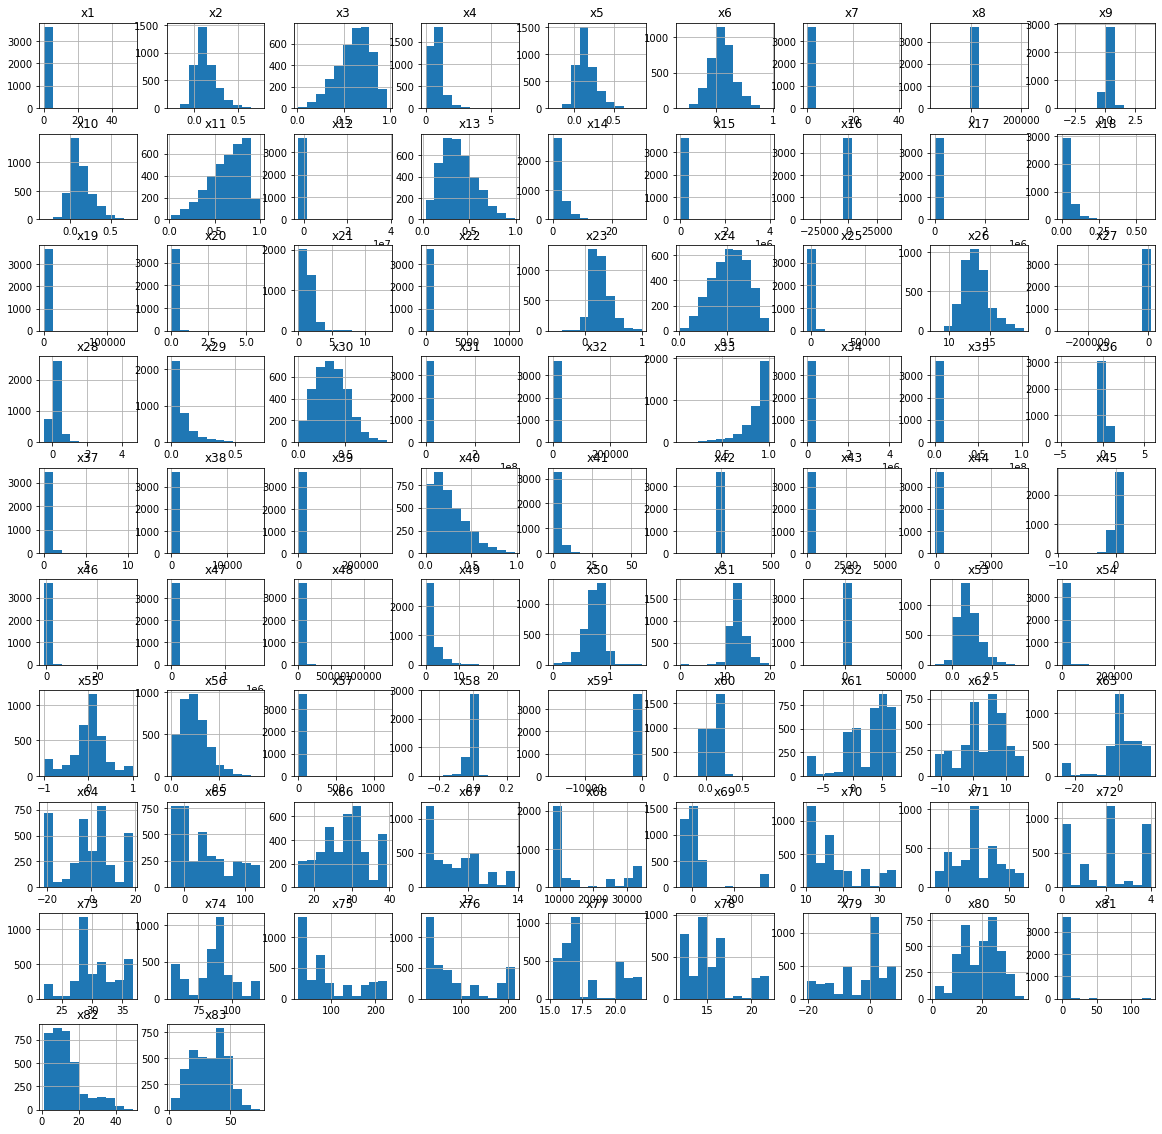

In [6]:
df.loc[:,"x1":].hist(figsize=(20, 20))
plt.show()

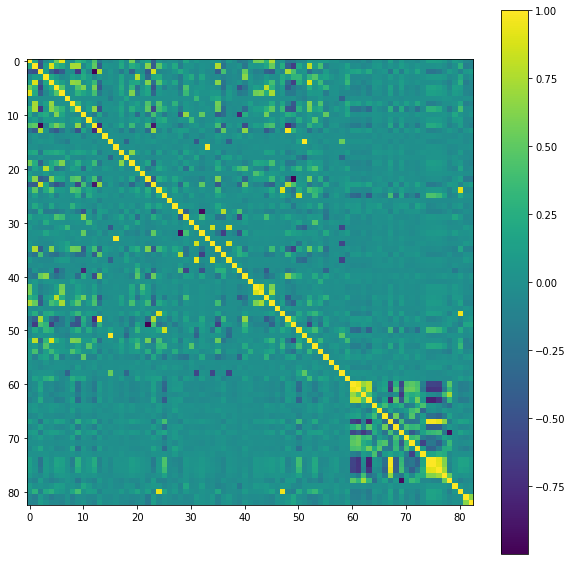

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(df.loc[:,"x1":].corr())
plt.colorbar()
plt.show()

^ It seems that after column *x60*, there's a very different part of a dataset connected. 
Maybe there are pre-computed features first and then manually tracked characterisics (a more categorical distribution of values may support that)

## Training data preparation

Let's first normalize the dataset (standardize with mean and standard deviation). 

Also, for simplicity, let's ignore the categorical *x80* feature.

In [8]:
columns = [f"x{i}" for i in set(range(1, 84)) - {80}]
df_X = df.loc[:,columns]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df_X)
norm_X = (df_X - df_X.mean()) / df_X.std()

Next, let's binarize the target variable according to the dataset description

In [10]:
labels = np.expand_dims(
    np.asarray(
        df.loc[:,"Financial Distress"] < -0.5,
        dtype=np.int_
    ),
    axis= -1
)


Finally, let's build some some evalution tools for later use:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix

def print_ratio(Y):
    print(f"{np.sum(Y)} / {len(Y)} = {np.sum(Y) / len(Y)}")

def evaluate(prediction, y_true, threshold):
    precision, recall, thresholds = precision_recall_curve(y_true, prediction)

    fig = plt.figure(figsize=(10, 8))
    s = plt.plot(recall, precision)
    plt.ylim((0.0, 1.1))
    plt.show()

    return confusion_matrix(test_Y, prediction > threshold)

## Simple feed-forward model

The goal for the first model is to predict whether a company will suffer with financial distress in the next year based on the data from the current year. 

Practically, we can streamline all timestamps into one trainnig dataset ignoring the time completely. We surely will create a unbalanced dataset but let't try anyway.

Next, let's use sklearn's `train_test_split` for convinient training/testing set generation

*Note the `stratify` parameter which is useful for unbalanced datasets*

In [12]:
train_X, test_X, train_Y, test_Y = train_test_split(norm_X.values, labels, test_size=0.3, shuffle=True, stratify=labels)

print(train_X.shape)
print_ratio(train_Y)
print_ratio(test_Y)

(2570, 82)
95 / 2570 = 0.03696498054474708
41 / 1102 = 0.03720508166969147


We may choose to oversample positive samples a bit to mitigate the disbanace of the training dataset

In [13]:
positive_samples = np.array([train_X[i] for i in range(len(train_X)) if train_Y[i]])

train_X = np.vstack([train_X, positive_samples, positive_samples])
train_Y = np.vstack([train_Y, np.full((len(positive_samples) * 2, 1), 1)])
print_ratio(train_Y)

285 / 2760 = 0.10326086956521739


The model is very simple, nothing surprising so far...

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense

inputs = Input(shape=(train_X.shape[-1],))
x = Dense(8, activation='relu')(inputs)
x = Dense(4, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

ffn_model = Model(inputs, outputs)
ffn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
ffn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 82)]              0         
                                                                 
 dense (Dense)               (None, 8)                 664       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [15]:
ffn_model.fit(train_X, train_Y, epochs=30, validation_data=(test_X, test_Y))

Epoch 1/30
87/87 [==============================] - 3s 7ms/step - loss: 0.5913 - accuracy: 0.8899 - val_loss: 0.4833 - val_accuracy: 0.9628
Epoch 2/30
87/87 [==============================] - 0s 6ms/step - loss: 0.4348 - accuracy: 0.8967 - val_loss: 0.3125 - val_accuracy: 0.9628
Epoch 3/30
87/87 [==============================] - 0s 4ms/step - loss: 0.3149 - accuracy: 0.8967 - val_loss: 0.2076 - val_accuracy: 0.9628
Epoch 4/30
87/87 [==============================] - 0s 4ms/step - loss: 0.2477 - accuracy: 0.8967 - val_loss: 0.1598 - val_accuracy: 0.9628
Epoch 5/30
87/87 [==============================] - 0s 4ms/step - loss: 0.2143 - accuracy: 0.8967 - val_loss: 0.1360 - val_accuracy: 0.9628
Epoch 6/30
87/87 [==============================] - 0s 5ms/step - loss: 0.1952 - accuracy: 0.8967 - val_loss: 0.1285 - val_accuracy: 0.9628
Epoch 7/30
87/87 [==============================] - 0s 4ms/step - loss: 0.1844 - accuracy: 0.8967 - val_loss: 0.1217 - val_accuracy: 0.9628
Epoch 8/30
87/87 [==

^ As we can see, the model starts overfitting almost immediately ...

35/35 [==============================] - 0s 1ms/step


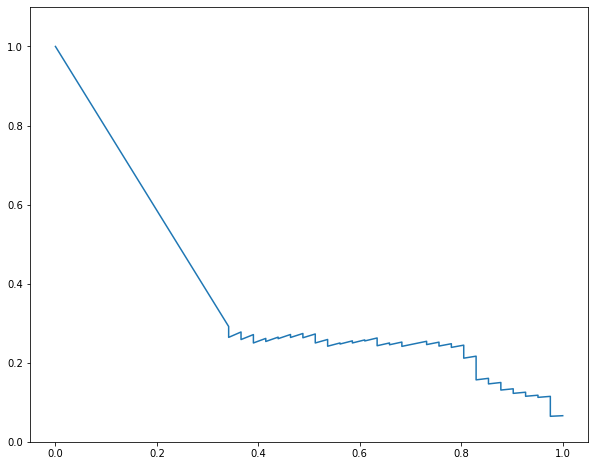

array([[968,  93],
       [ 10,  31]])

In [16]:
threshold = 0.1
prediction = ffn_model.predict(test_X)
evaluate(prediction, test_Y, threshold)

^ We get to a model which seems to be better than random but far from optimum. The time property is not used at all, most of the data are actually not that interesting as it describes a "healthy" company from the target variable point of view.

We should be able to get better results with recurrent networks.

## LSTM sequence classification

The second model utilizes the time property and tries to predict the financial distress for the next year from the current and past years.

First, we need to reorganize the dataset and split it into time series:

In [17]:
seq_X = []
Y = []
companies = []

for company_id in df.loc[:,"Company"].unique():
    company_index = df[df["Company"] == company_id].index
    sample = norm_X.loc[company_index].values
    seq_X.append(sample)
    Y.append(labels[company_index[-1]])
    companies.append(company_id)

Now, let's the distribution of lenghts of time series we just created

*(blue=distress, orange=healthy)*

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


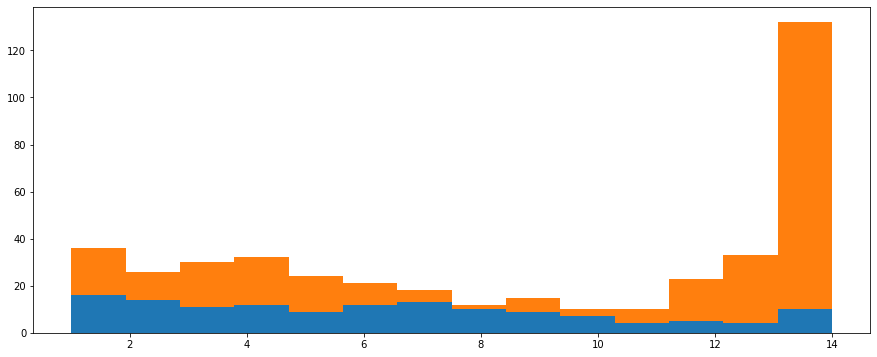

In [18]:
lengths = (
    [s.shape[0] for s, y in zip(seq_X, Y) if y], 
    [s.shape[0] for s, y in zip(seq_X, Y) if not y]
)
plt.hist(lengths, histtype='barstacked', bins=14)
plt.show()

^ It seems we have an unbalanced distribution where most of the healty companies have long financial records (14 years)

*Also, it seems that according to this dataset, having a company 8 years old is a very risky business :)*

Anyway, we should lenght-normalize the dataset to not allow the model to use the lenght of the record as a hint for detection of the healthy company (which RNNs can definitely exploit).

One possible way is to trim the long healthy companies randomly and leave only several recent years:

In [19]:
seq_X = []
Y = []
companies = []

for company_id in df.loc[:,"Company"].unique():
    company_index = df[df["Company"] == company_id].index
    sample = norm_X.loc[company_index].values          
    label = labels[company_index[-1]]
    if len(sample) > 13 and not label:    
        offset = random.randint(0,13) if random.random() > 0.2 else 0
        seq_X.append(sample[offset:14])        
    else:
        seq_X.append(sample)
    Y.append(label)
    companies.append(company_id)

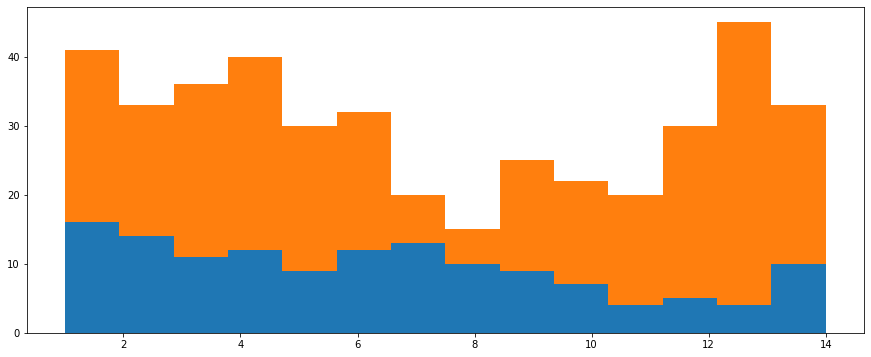

In [20]:
lengths = (
    [s.shape[0] for s, y in zip(seq_X, Y) if y], 
    [s.shape[0] for s, y in zip(seq_X, Y) if not y]
)
plt.hist(lengths, histtype='barstacked', bins=14)
plt.show()

^ Now, we have much better distribution i.e. the length of record is harder to use as an input feature.

In [21]:
print(f"{np.sum(Y)} / {len(Y)} = {np.sum(Y) / len(Y)}")

136 / 422 = 0.3222748815165877


^ With sequences we have way less training samples (422) but much better label ratio.

Next, we need to pad sequences to a fixed length (or create se set of fixed batches, try it for your own!)

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X = pad_sequences(seq_X, maxlen=14, dtype=seq_X[0].dtype)
Y = np.array(Y)

For trail test split, let's also store company id for later use.

In [23]:
train_X, test_X, train_Y, test_Y, train_companies, test_companies = train_test_split(padded_X, Y, companies, test_size=0.3, shuffle=True, stratify=Y)

print(train_X.shape)
print(train_Y.shape)

(295, 14, 82)
(295, 1)


In [24]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout

inputs = Input(shape=(None, train_X.shape[-1],))
x = LSTM(32)(inputs)
outputs = Dense(1, activation='sigmoid')(x)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 82)]        0         
                                                                 
 lstm (LSTM)                 (None, 32)                14720     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,753
Trainable params: 14,753
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=10)

Epoch 1/10
10/10 [==============================] - 4s 97ms/step - loss: 0.4119 - accuracy: 0.8915 - val_loss: 0.3285 - val_accuracy: 0.9213
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.2678 - accuracy: 0.9356 - val_loss: 0.2700 - val_accuracy: 0.9213
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.2131 - accuracy: 0.9424 - val_loss: 0.2476 - val_accuracy: 0.9291
Epoch 4/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1813 - accuracy: 0.9492 - val_loss: 0.2349 - val_accuracy: 0.9213
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.1560 - accuracy: 0.9525 - val_loss: 0.2302 - val_accuracy: 0.9291
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 0.1383 - accuracy: 0.9593 - val_loss: 0.2288 - val_accuracy: 0.9291
Epoch 7/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1245 - accuracy: 0.9559 - val_loss: 0.2246 - val_accuracy: 0.9134
Epoch 8/10
10

4/4 [==============================] - 1s 7ms/step


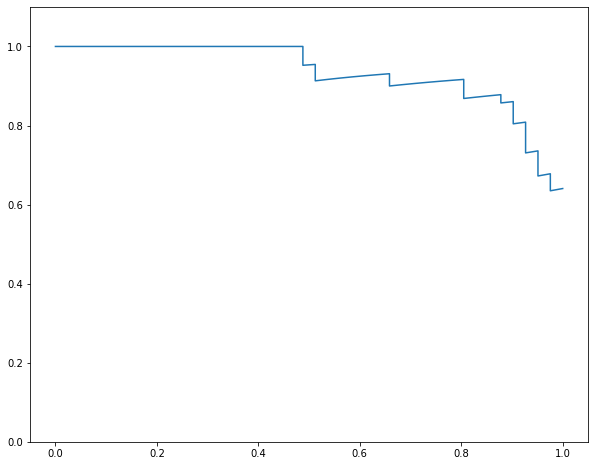

array([[79,  7],
       [ 4, 37]])

In [26]:
threshold = 0.4
prediction = lstm_model.predict(test_X)
evaluate(prediction, test_Y, threshold)

This looks much better but does it really works? 
Let's test the model from the original unpadded data.

**To stress test generalization, let's trim 40% of the testing data from the begining.**

In [28]:
all_y_true = []
all_y_pred = []

for company_id in tqdm(test_companies):
    samples = df[df["Company"] == company_id]    
    x = scaler.transform(samples.loc[:,columns])
    y_true = samples.loc[:,"Financial Distress"].values[-1] < -0.5       
    offset = int(len(x) * 0.4)
    y_pred = lstm_model.predict(np.expand_dims(x[offset:], 0), verbose=False)[0]    
    all_y_true.append(y_true)
    all_y_pred.append(y_pred)    

  0%|          | 0/127 [00:00<?, ?it/s]

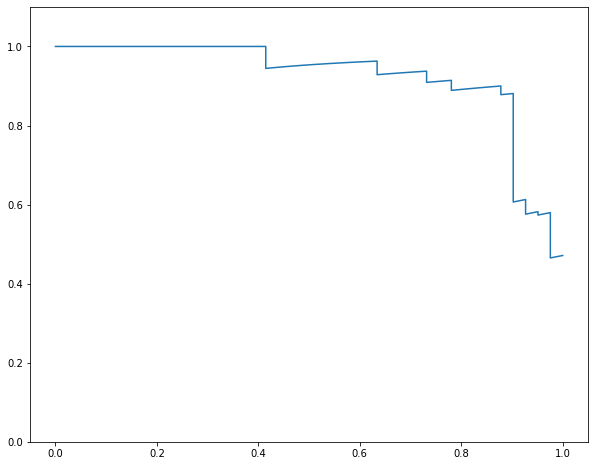

array([[80,  6],
       [ 4, 37]])

In [29]:
evaluate(np.array(all_y_pred), all_y_true, threshold)

## LSTM Model - Regression 

Now, let' try regression task i.e.:

*Could we predict the level of financial distress next year?*

The task does not require a very different model, we just need to alter the output variable a little bit. Let's apply `tanh` at the output so it keeps its descriptive power but remains in a reasonable range (-1, 1)

In [30]:
fin_stress = df.loc[:,"Financial Distress"]
target_mean = fin_stress.mean()
target_std = fin_stress.std()

def normalize_target(t):
    return np.tanh((t - target_mean) / target_std)

def denormalize_target(t):
    return np.arctanh(t) * target_std + target_mean

norm_stress_level = normalize_target(-0.5)

The rest od the code is fairly similar to the classification

In [31]:
seq_X = []
seq_Y = []
Y = []
companies = []

for company_id in df.loc[:,"Company"].unique():
    company_index = df[df["Company"] == company_id].index    

    sample = norm_X.loc[company_index].values
    target = normalize_target(df.loc[company_index,"Financial Distress"].values)

    if len(sample) > 13 and not label:    
        offset = random.randint(0,13) if random.random() > 0.2 else 0
        seq_X.append(sample[offset:])        
        seq_Y.append(target[offset:])
    else:
        seq_X.append(sample)    
        seq_Y.append(target)
        
    Y.append(target[-1])

    companies.append(company_id)

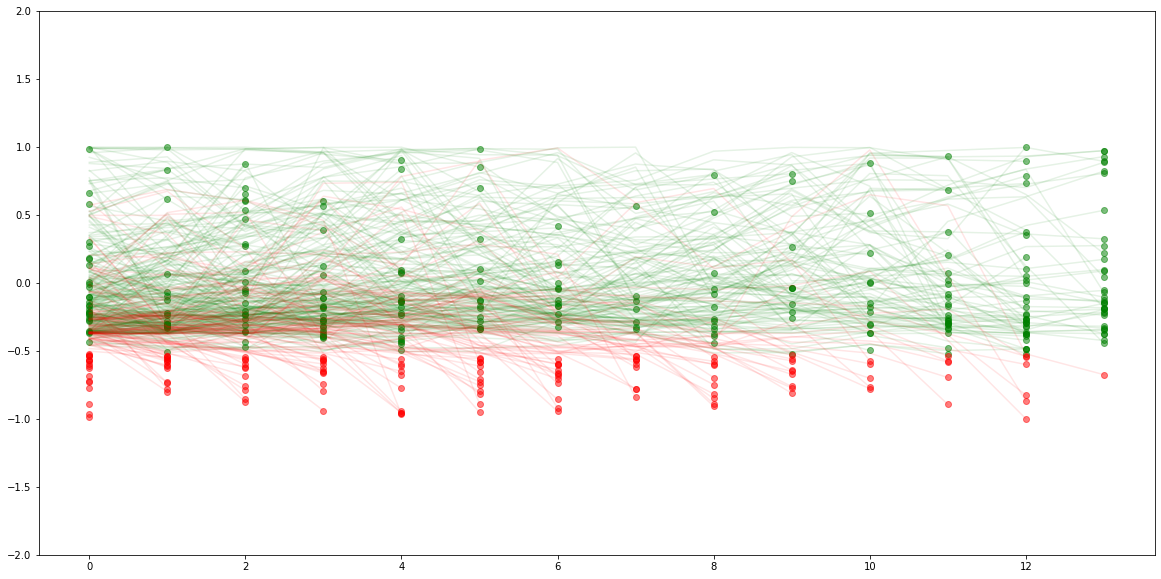

In [32]:
def is_stressed(seq):
    return seq[-1] < norm_stress_level

plt.figure(figsize=(20, 10))
for seq in sorted(seq_Y, key=is_stressed):
    color = "r" if is_stressed(seq) else "g"
    plt.plot(seq, c=color, alpha=0.1)
    plt.scatter(len(seq) - 1, seq[-1], c=color, alpha=0.5)    

plt.ylim((-2, 2))
plt.show()    

^ This is how the target variable looks like after transformation.

In [33]:
padded_X = pad_sequences(seq_X, maxlen=14, dtype=seq_X[0].dtype)
padded_Y = pad_sequences(seq_Y, maxlen=14, dtype=seq_Y[0].dtype)

In [34]:
seq_train_X, seq_test_X, seq_train_Y, seq_test_Y, train_Y, test_Y, train_companies, test_companies = (
    train_test_split(padded_X, padded_Y, np.array(Y), companies, test_size=0.3, shuffle=True)
)

print(seq_train_X.shape)
print(seq_train_Y.shape)

(295, 14, 82)
(295, 14)


In [35]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout

inputs = Input(shape=(None, seq_train_X.shape[-1],))
x = LSTM(32, return_sequences=False)(inputs)
outputs = Dense(1, activation='tanh')(x)

lstm_model = Model(inputs, outputs)
lstm_model.compile(optimizer='rmsprop', loss='mse')
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 82)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                14720     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,753
Trainable params: 14,753
Non-trainable params: 0
_________________________________________________________________


In [36]:
lstm_model.fit(seq_train_X, train_Y, validation_data=(seq_test_X, test_Y), epochs=10)

Epoch 1/10
10/10 [==============================] - 4s 88ms/step - loss: 0.2103 - val_loss: 0.1329
Epoch 2/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0946 - val_loss: 0.1122
Epoch 3/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0715 - val_loss: 0.1076
Epoch 4/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0602 - val_loss: 0.1083
Epoch 5/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0523 - val_loss: 0.1053
Epoch 6/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0443 - val_loss: 0.0997
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.0394 - val_loss: 0.1040
Epoch 8/10
10/10 [==============================] - 0s 17ms/step - loss: 0.0342 - val_loss: 0.0958
Epoch 9/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0306 - val_loss: 0.1142
Epoch 10/10
10/10 [==============================] - 0s 14ms/step - loss: 0.0281 - val_loss: 0.1006


In [37]:
prediction = lstm_model.predict(seq_test_X)

4/4 [==============================] - 1s 6ms/step


We can still trurn the model prediction into classification to compare it with the previous attempt.

In [38]:
confusion_matrix(test_Y < norm_stress_level, prediction < norm_stress_level)

array([[82,  9],
       [ 9, 27]])

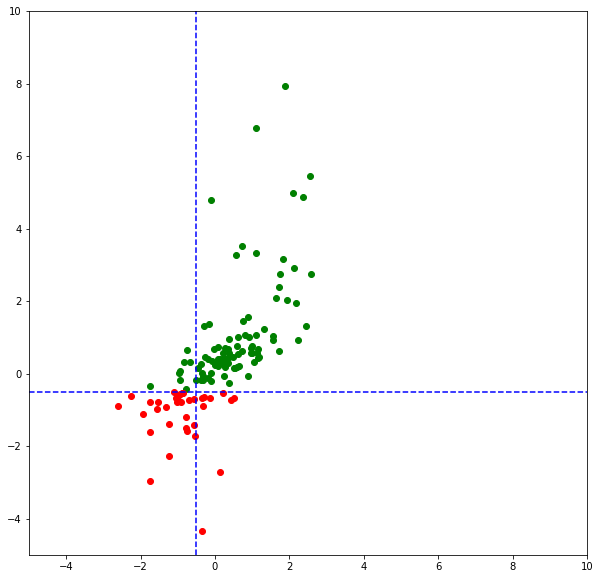

In [39]:
def is_stressed(y):
    return y < norm_stress_level

plt.figure(figsize=(10,10))
plt.hlines(-0.5, -5, 10, color='b', linestyles='dashed')
plt.vlines(-0.5, -5, 10, color='b', linestyles='dashed')

for y_pred, y_true in zip(prediction[:,-1], test_Y):
    color = "r" if is_stressed(y_true) else "g"            
    plt.scatter(denormalize_target(y_pred), denormalize_target(y_true), c=color)

plt.ylim((-5, 10))
plt.xlim((-5, 10))
plt.show()     

^ We can also plot target and output values as scatterplot forming a continuous "confusion matrix" with said threshold (-0.5) for both axes. FNs and FPs errors are in lower-right box and upper-left box respectively.

*Note: An ideal model would form a perfect diagonal line of samples.*

## Feature weights analysis

Neural Networks are "black-box" models, and frequently, it's very hard to interpret what's going on inside the model nor which input features has been most useful for the goal task.

There are several methods for "neural networks interpretability" (see [this publication](https://arxiv.org/pdf/2001.02522.pdf) but let's try a very simple method how in some cases, importance of input features can be discovered:

First, a little plot twist. It turned out that the model we build is unnecessary complex and that just one recurrent unit is able to correctly predict the target variable. Let's test that.

In [40]:
seq_X = []
Y = []
companies = []

for company_id in df.loc[:,"Company"].unique():
    company_index = df[df["Company"] == company_id].index
    sample = norm_X.loc[company_index].values          
    label = labels[company_index[-1]]
    if len(sample) > 13 and not label:    
        offset = random.randint(0,13) if random.random() > 0.2 else 0
        seq_X.append(sample[offset:14])        
    else:
        seq_X.append(sample)
    Y.append(label)
    companies.append(company_id)


padded_X = pad_sequences(seq_X, maxlen=14, dtype=seq_X[0].dtype)
Y = np.array(Y)

train_X, test_X, train_Y, test_Y, train_companies, test_companies = train_test_split(padded_X, Y, companies, test_size=0.3, shuffle=True, stratify=Y)

print(train_X.shape)
print(train_Y.shape)

(295, 14, 82)
(295, 1)


In [41]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout, SimpleRNN
from tensorflow.keras.regularizers import L1

inputs = Input(shape=(None, train_X.shape[-1],))
outputs = SimpleRNN(1, activation='sigmoid', kernel_regularizer=L1(0.03))(inputs)

simple_model = Model(inputs, outputs)
simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simple_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 82)]        0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1)                 84        
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


In [ ]:
simple_model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=200)

Epoch 1/200
10/10 [==============================] - 0s 22ms/step - loss: 1.0309 - accuracy: 0.6576 - val_loss: 0.9392 - val_accuracy: 0.7480
Epoch 2/200
10/10 [==============================] - 0s 5ms/step - loss: 0.9488 - accuracy: 0.7017 - val_loss: 0.8668 - val_accuracy: 0.7795
Epoch 3/200
10/10 [==============================] - 0s 5ms/step - loss: 0.8796 - accuracy: 0.7322 - val_loss: 0.8046 - val_accuracy: 0.8268
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8214 - accuracy: 0.7661 - val_loss: 0.7502 - val_accuracy: 0.8268
Epoch 5/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7719 - accuracy: 0.7932 - val_loss: 0.7033 - val_accuracy: 0.8268
Epoch 6/200
10/10 [==============================] - 0s 5ms/step - loss: 0.7280 - accuracy: 0.8169 - val_loss: 0.6635 - val_accuracy: 0.8504
Epoch 7/200
10/10 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.8441 - val_loss: 0.6297 - val_accuracy: 0.8661
Epoch 8/200


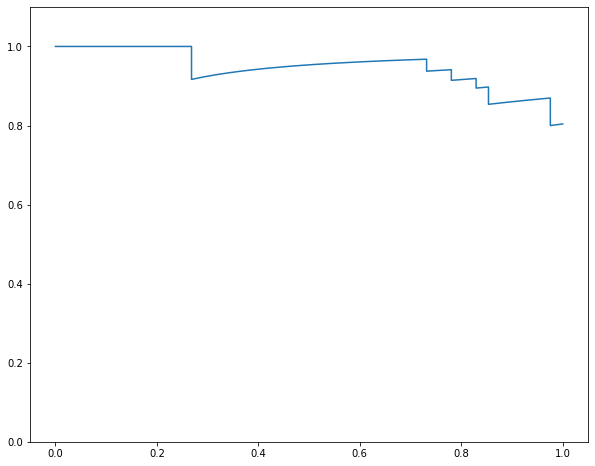

array([[80,  6],
       [ 4, 37]])

In [ ]:
threshold = 0.4
prediction = simple_model.predict(test_X)
evaluate(prediction, test_Y, threshold)

While the model requires more epochs to converge, it definitely can correctly predict the test set.

*Note: This open up a question if a neural network is really necessary for the task as one simple recurrent unit is practically a logistic regression with one auto-regressive term and backpropagation with binary cross entropy is practically a likelihood maximization.*

Next, we can peek into the insides of the model and look at the weights of the recurrent unit:

<BarContainer object of 82 artists>

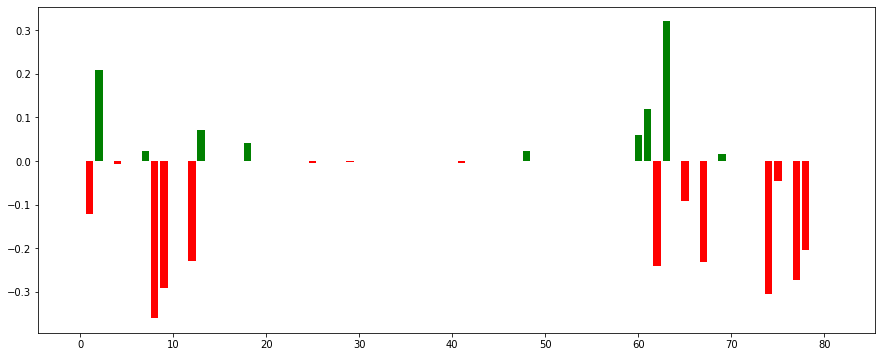

In [ ]:
weights = simple_model.layers[1].weights[0].numpy().squeeze()
plt.bar(range(len(weights)), np.clip(weights, a_min=0.0, a_max=None), color='g')
plt.bar(range(len(weights)), np.clip(weights, a_min=None, a_max=0.0), color='r')

^ As you an see, the weight vector is quite sparse and this was achieved by adding a **L1 regularization** to the model. The L1 regularization imposed on a neuron "kernel" i.e. input weights will produce such sparse distribution of weights. It also forces the model to "choose" features that are most effective for prediction.

On the other hand, some features might be correlated so the model can choose different features for different initial configuration. Therefore, let's do some cross training to find out if there are any significant features that get often selected.

In [ ]:
NUM_TRIALS = 100

accum_weights = []

for i in tqdm(range(NUM_TRIALS)):
    inputs = Input(shape=(None, train_X.shape[-1],))
    outputs = SimpleRNN(1, activation='sigmoid', kernel_regularizer=L1(0.03))(inputs)

    simple_model = Model(inputs, outputs)
    simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    train_X, test_X, train_Y, test_Y, _, _ = train_test_split(padded_X, Y, companies, test_size=0.3, shuffle=True, stratify=Y)

    result = simple_model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=200, verbose=0)
    val_acc = result.history['val_accuracy'][-1]
    if val_acc > 0.9:
        accum_weights.append(simple_model.layers[1].weights[0].numpy().squeeze())
    else:
        print("Not converged: ", val_acc)

Not converged:  0.8818897604942322
Not converged:  0.8818897604942322
Not converged:  0.8976377844810486
Not converged:  0.8818897604942322
Not converged:  0.8818897604942322
Not converged:  0.8976377844810486
Not converged:  0.8976377844810486
Not converged:  0.874015748500824
Not converged:  0.8976377844810486
Not converged:  0.8818897604942322
Not converged:  0.8976377844810486
Not converged:  0.8897637724876404



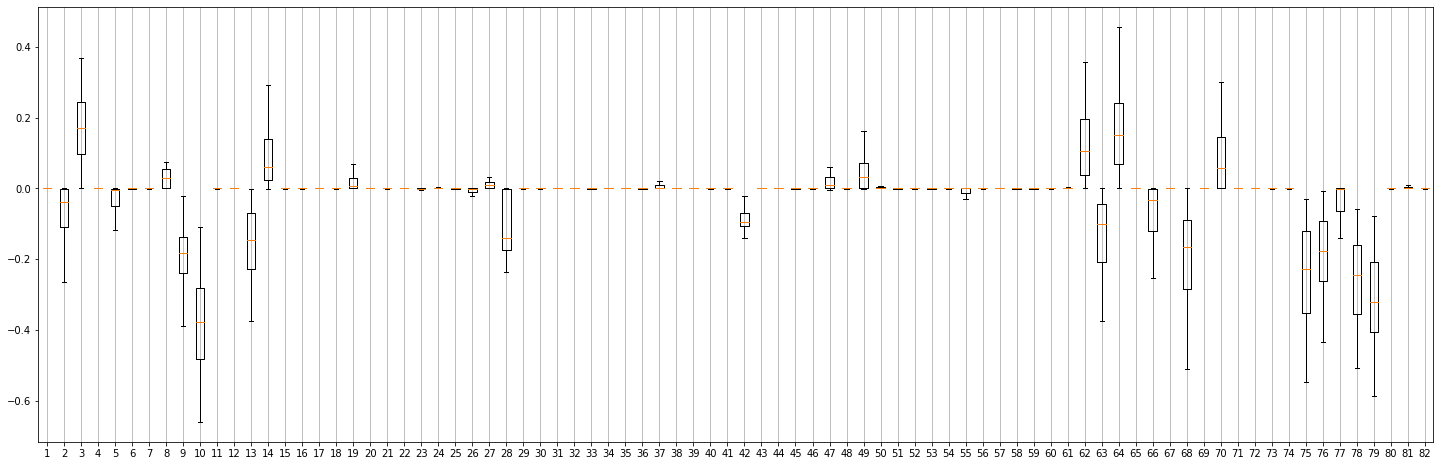

In [ ]:
plt.figure(figsize=(25, 8))
plt.boxplot(np.array(accum_weights), showfliers=False)
plt.grid(axis='x')
plt.show()

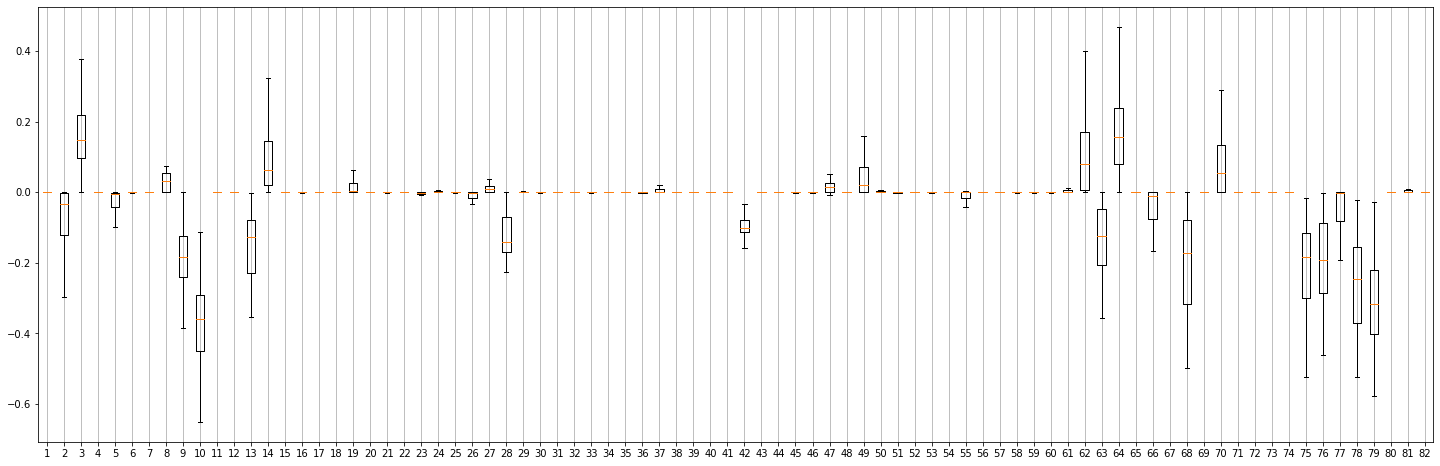

In [ ]:
plt.figure(figsize=(25, 8))
plt.boxplot(np.array(accum_weights), showfliers=False)
plt.grid(axis='x')
plt.show()